In [23]:
# visualization 
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
import pandas as pd
import numpy as np
import unicodedata
import re

# embedding
from sentence_transformers import SentenceTransformer

# dimension reduction
from umap import UMAP
from sklearn.decomposition import PCA

# clustering
from hdbscan import HDBSCAN

# tokenization
import requests
from fugashi import Tagger
from sklearn.feature_extraction.text import CountVectorizer

#c-TF-IDF
from bertopic.vectorizers import ClassTfidfTransformer

# representations
import spacy
import ginza # dictionary
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech

#---
from bertopic import BERTopic

In [3]:
df = pd.read_csv('./data/books_final.csv', usecols=['id', 'char_count', 'author_id', 'text'])

df

id  author_id  char_count  \
0      54333       1657     80156.0   
1      46340       1234     76104.0   
2      46511       1245      2975.0   
3      57975       1245      2516.0   
4      57976       1245       585.0   
...      ...        ...         ...   
17365  49911       1395      4761.0   
17366  55622       1395     12400.0   
17367  49876       1395      4655.0   
17368  49913       1395     12075.0   
17369  49914       1395      4146.0   

                                                    text  
0      著者フレデリック・アークム専門化学者、ヨーロッパの主な芸術・科学アカデミーおよび学会の会員緒...  
1      ［＃改丁］序偉人の伝記というと、ナポレオンとかアレキサンドロスとか、グラッドストーンというよ...  
2      人間が石にたよるやうになつて、もうよほど久しいことであるのに、まだ根気よくそれをやつてゐる。...  
3      既に美育部を持つてゐる早稻田中學校が新に音樂會を興してその發會式をやらうとする其の日から、又...  
4      古い日記や手紙などを、みんな燒いてしまつたので、こまかに時日をいへないが、まだ若い中學教師で...  
...                                                  ...  
17365  問題にしない時にはわかり切ったことと思われているものが、さて問題にしてみると実にわからなくな...  
17366  夢の話をするのはあまり気のきいたことではない。確か痴人夢を説くという言葉があったはずだ。そう...  
17367  自分は現代の画家中に岸田君ほど明らかな「成長」を示している人を知らない。誇張でなく岸田君は一...  
17368  一荒漠たる秋の野に立つ。星は月の御座を囲み月は清らかに地の花を輝らす。花は紅と咲き黄と匂い紫...  
17369  関東大震災の前数年の間、先輩たちにまじって露伴先生から俳諧の指導をうけたことがある。その時の...  

[17370 rows x 4 columns]

#### Preprocessing

In [3]:
df['char_count'].describe()

count     17370.000000
mean      13456.169315
std       34426.686869
min          14.000000
25%        1531.250000
50%        4314.000000
75%       11550.500000
max      823518.000000
Name: char_count, dtype: float64

In [12]:
len(df[df['char_count'] < 100])

406

In [4]:
def preprocess(txt):
    txt = re.sub(r'[^\w\s]', '', txt) # remove all punctuation
    txt = unicodedata.normalize('NFKC', txt) # standardizing japanese characters (全角 vs 半角)
    return txt

df['text'] = df['text'].apply(preprocess)


In [22]:
df['text'].head(5)

0    著者フレデリックアークム専門化学者ヨーロッパの主な芸術科学アカデミーおよび学会の会員緒言この...
1    改丁序偉人の伝記というとナポレオンとかアレキサンドロスとかグラッドストーンというようなのばか...
2    人間が石にたよるやうになつてもうよほど久しいことであるのにまだ根気よくそれをやつてゐる石にた...
3    既に美育部を持つてゐる早稻田中學校が新に音樂會を興してその發會式をやらうとする其の日から又病...
4    古い日記や手紙などをみんな燒いてしまつたのでこまかに時日をいへないがまだ若い中學教師であつた...
Name: text, dtype: object

In [5]:
def is_all_english(text):
    if bool(re.fullmatch(r'[A-Za-z\s]+', text)): # all english
        return True
    else:
        return False

df['all_eng'] = df['text'].apply(is_all_english)

In [57]:
df[df['all_eng']]

id  author_id  char_count  \
1279   55213        235        87.0   
1280   55214        235        81.0   
8178   54811       1675       100.0   
17218    888        163        96.0   

                                                    text  all_eng  
1279   UrbinonowakdokosowaedakuminoichitotatreLeonard...     True  
1280   KonataniwaAbruzzinoyamakanataPontininonumaGeij...     True  
8178   IshikoronomichiIshikoronomichiKaattohigasenawo...     True  
17218  HowkindhowfairshewashowgoodIcannottellyouIfIco...     True

In [6]:
df = df[~df['all_eng']].reset_index(drop=True)

df = df.drop(columns='all_eng')

In [7]:
df['text'] = df['text'].astype(str)

#### Embedding

In [66]:
text = df['text'].sample(1000)

In [8]:
embedding_model = SentenceTransformer("intfloat/multilingual-e5-small")

In [ ]:


all_embeddings = []
for i in range(0, len(df['text']), 1000):
    batch = df['text'][i:i+1000].values

    emb = embedding_model.encode(batch, batch_size=4, show_progress_bar=True)
    all_embeddings.append(emb)

all_embeddings = np.vstack(all_embeddings)


Batches: 100%|██████████| 92/92 [01:08<00:00,  1.34it/s]


In [5]:
all_embeddings.shape

(17366, 384)

#### Dimension Reduction

##### PCA

In [ ]:
# I'm not scaling/standardizing the data as all numbers are on the same scale.
pca = PCA(n_components=20)
x = pca.fit_transform(all_embeddings)
for i, component in enumerate(pca.components_):
    print("{}th component: {:.2f}% of initial variance".format(i + 1, 100 * pca.explained_variance_ratio_[i]))

1th component: 3.60% of initial variance
2th component: 3.12% of initial variance
3th component: 2.30% of initial variance
4th component: 1.81% of initial variance
5th component: 1.44% of initial variance
6th component: 1.37% of initial variance
7th component: 1.31% of initial variance
8th component: 1.25% of initial variance
9th component: 1.11% of initial variance
10th component: 1.02% of initial variance
11th component: 0.99% of initial variance
12th component: 0.93% of initial variance
13th component: 0.92% of initial variance
14th component: 0.82% of initial variance
15th component: 0.79% of initial variance
16th component: 0.75% of initial variance
17th component: 0.74% of initial variance
18th component: 0.71% of initial variance
19th component: 0.67% of initial variance
20th component: 0.66% of initial variance


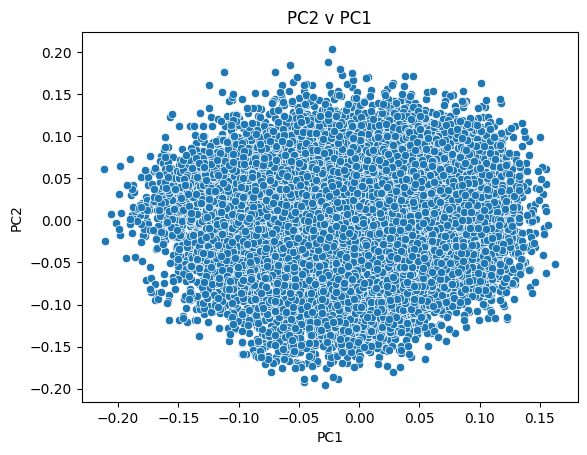

In [24]:
ax = sns.scatterplot(x=x[:, 0], y=x[:, 1]);
ax.set_ylabel('PC2');
ax.set_xlabel('PC1');
ax.set_title('PC2 v PC1');


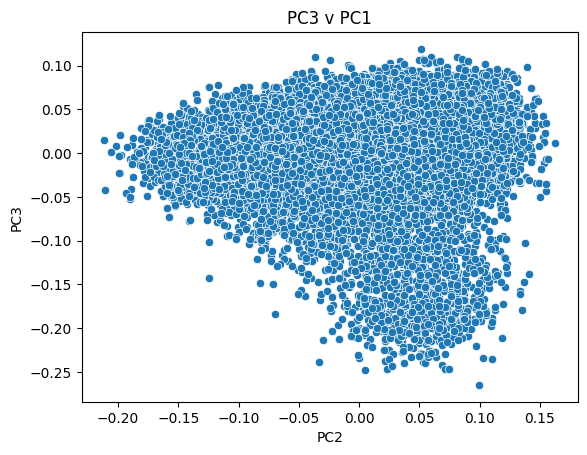

In [ ]:
ax = sns.scatterplot(x=x[:, 0], y=x[:, 2]);
ax.set_ylabel('PC3');
ax.set_xlabel('PC1');
ax.set_title('PC3 v PC1');


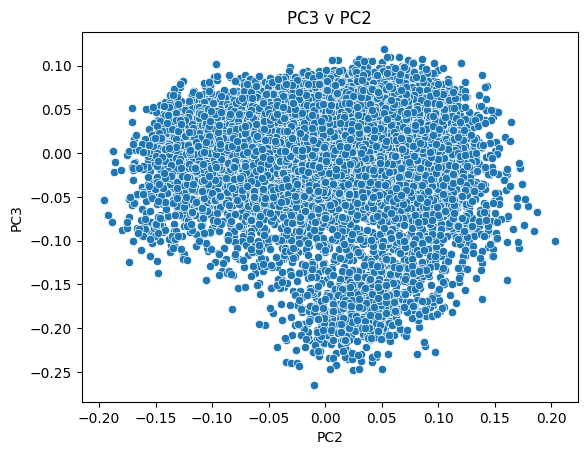

In [32]:
ax = sns.scatterplot(x=x[:, 1], y=x[:, 2]);
ax.set_ylabel('PC3');
ax.set_xlabel('PC2');
ax.set_title('PC3 v PC2');

PCA is clearly not performing very well, with PC1 and PC2 only being able to explain less than 7% of the total original variance.

##### UMAP 

In [44]:
umap = UMAP(n_neighbors=15, n_components=5, min_dist=0.5, metric='cosine', random_state=98)

u = umap.fit_transform(all_embeddings)

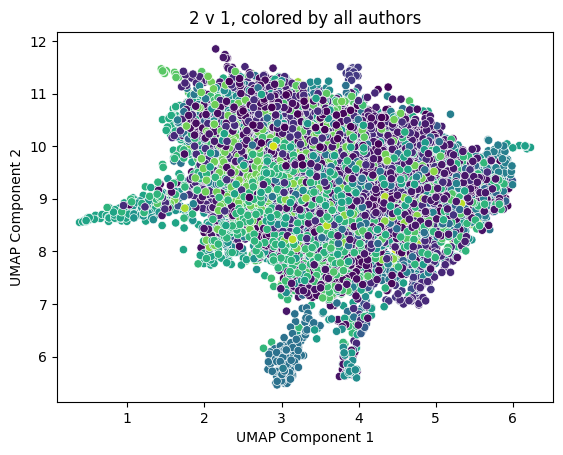

In [66]:
ax = sns.scatterplot(x=u[:, 0], y=u[:, 1], c=df['author_id'])
ax.set_ylabel('UMAP Component 2');
ax.set_xlabel('UMAP Component 1');
ax.set_title('2 v 1, colored by all authors');


In [91]:
def plot_by_author(author_id, author):
    works_by_author = df['author_id'] == author_id

    # plot works that are not by author
    sns.scatterplot(
    x=u[works_by_author == False, 0], 
    y=u[works_by_author == False, 1],
    color="lightgrey",
    alpha=0.3
    )
    
    # plot works that are by author
    sns.scatterplot(
    x=u[works_by_author == True, 0],
    y=u[works_by_author == True, 1],
    color="red",
    alpha=0.8
    )

    # labels
    plt.ylabel('UMAP Component 2')
    plt.xlabel('UMAP Component 1')
    plt.title('2 v 1 — Highlighting {}'.format(author))
    plt.show()



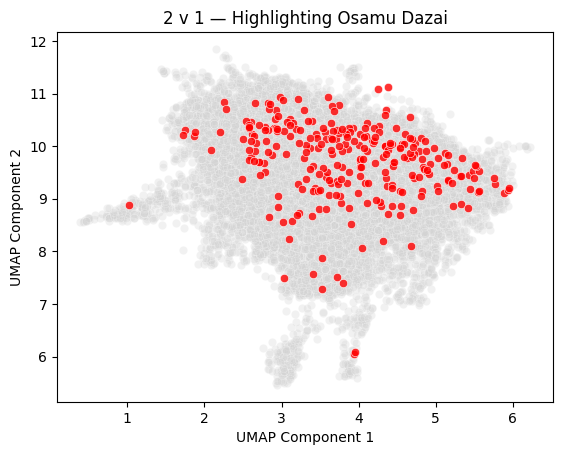

In [92]:
plot_by_author(35, 'Osamu Dazai')

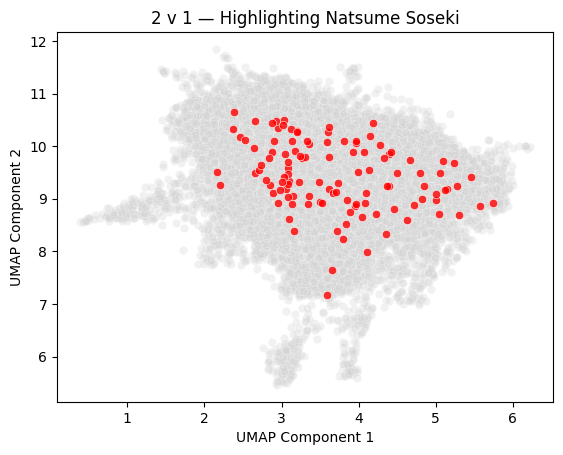

In [93]:
plot_by_author(148, 'Natsume Soseki')

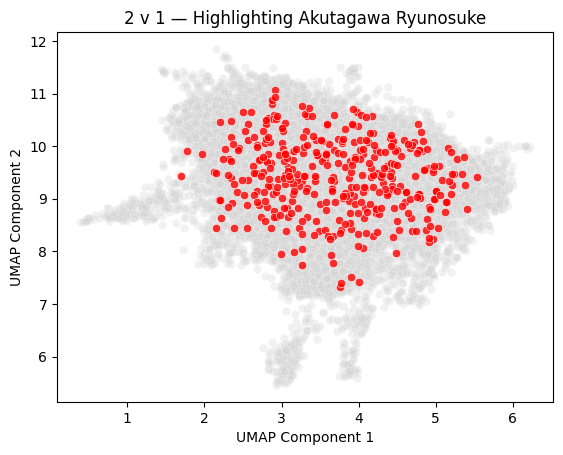

In [94]:
plot_by_author(879, 'Akutagawa Ryunosuke')

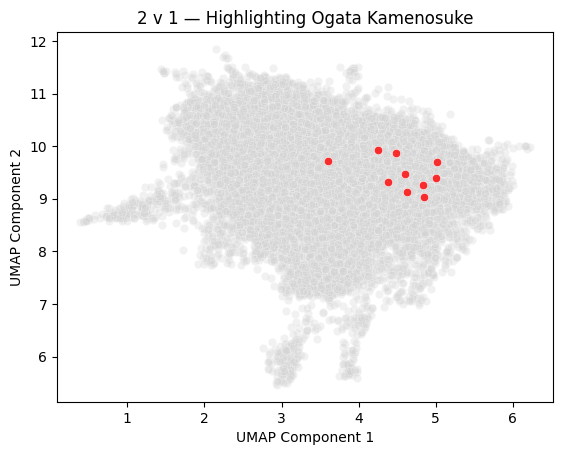

In [95]:
plot_by_author(874, 'Ogata Kamenosuke')

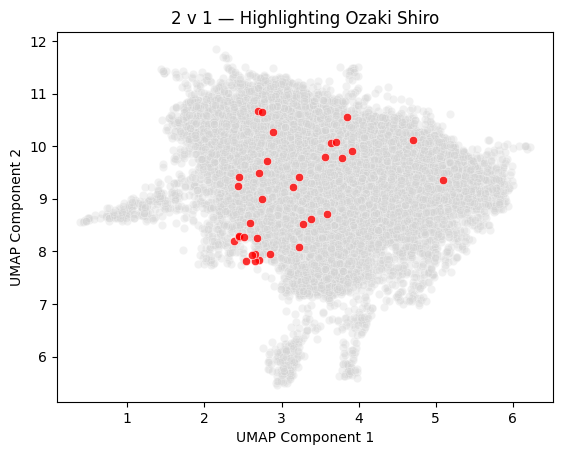

In [96]:
plot_by_author(1753, 'Ozaki Shiro')

In [97]:
umap = UMAP(n_neighbors=30, n_components=5, min_dist=0.5, metric='cosine', random_state=98)

u = umap.fit_transform(all_embeddings)

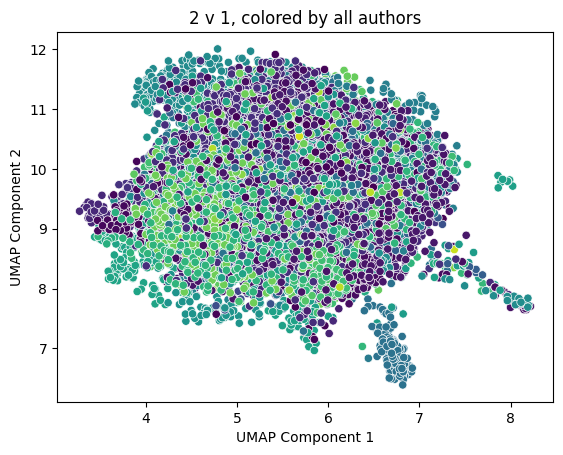

In [101]:
ax = sns.scatterplot(x=u[:, 0], y=u[:, 1], c=df['author_id'])
ax.set_ylabel('UMAP Component 2');
ax.set_xlabel('UMAP Component 1');
ax.set_title('2 v 1, colored by all authors');

In [102]:
def plot_all_authors():
    plot_by_author(1753, 'Ozaki Shiro')
    plot_by_author(874, 'Ogata Kamenosuke')
    plot_by_author(879, 'Akutagawa Ryunosuke')
    plot_by_author(148, 'Natsume Soseki')
    plot_by_author(35, 'Osamu Dazai')

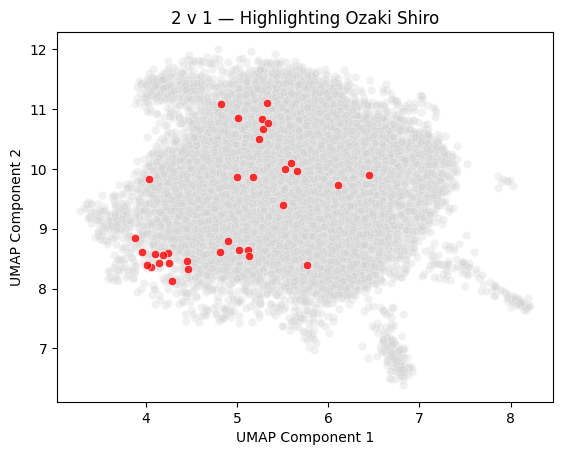

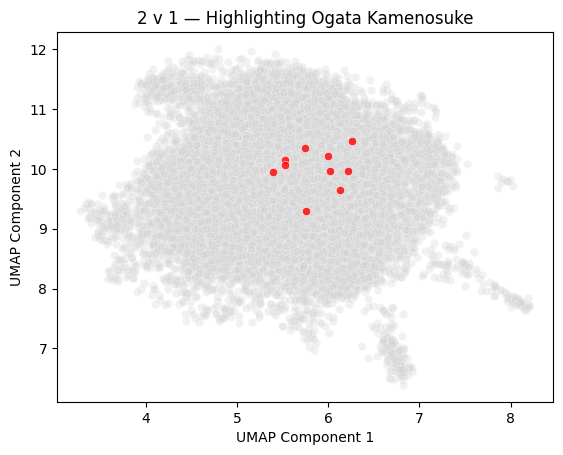

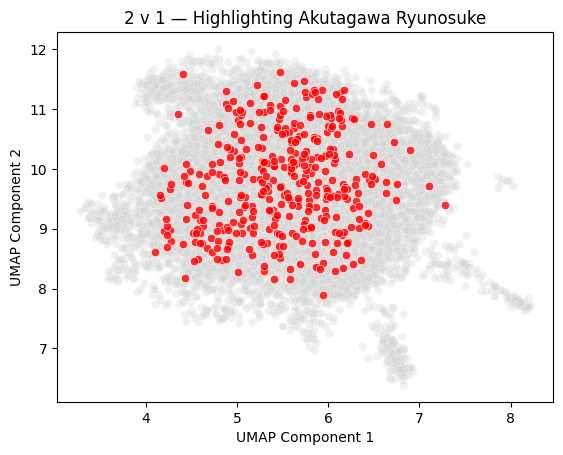

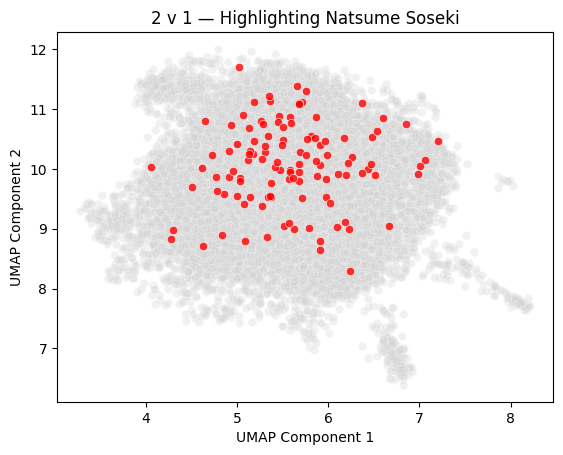

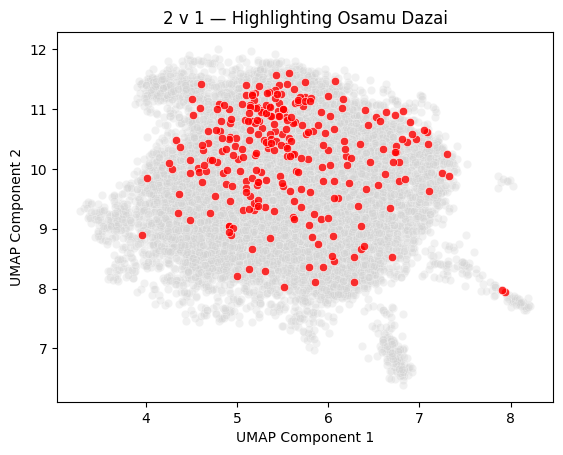

In [103]:
plot_all_authors()

Let's try less neighbors to try and capture more local structures. Hopefully this would incentivize subclusters for each author's works.

In [104]:
umap = UMAP(n_neighbors=5, n_components=5, min_dist=0.5, metric='cosine', random_state=98)

u = umap.fit_transform(all_embeddings)

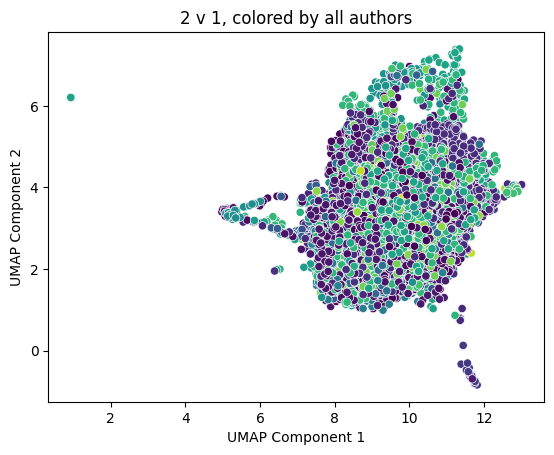

In [106]:
ax = sns.scatterplot(x=u[:, 0], y=u[:, 1], c=df['author_id'])
ax.set_ylabel('UMAP Component 2');
ax.set_xlabel('UMAP Component 1');
ax.set_title('2 v 1, colored by all authors');

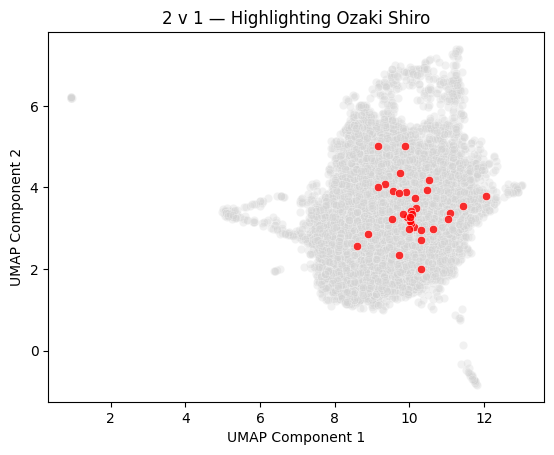

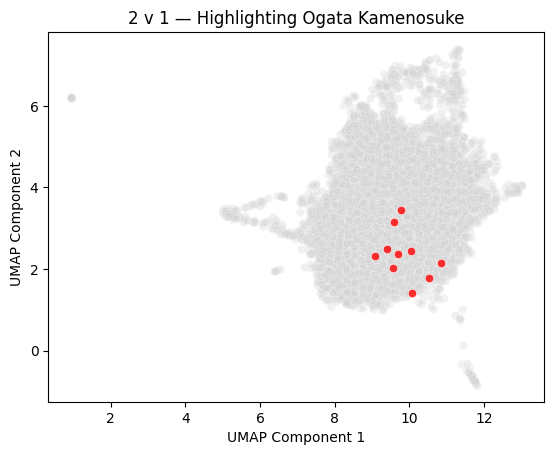

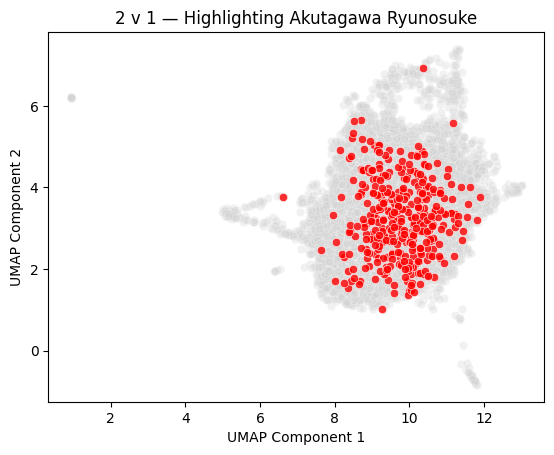

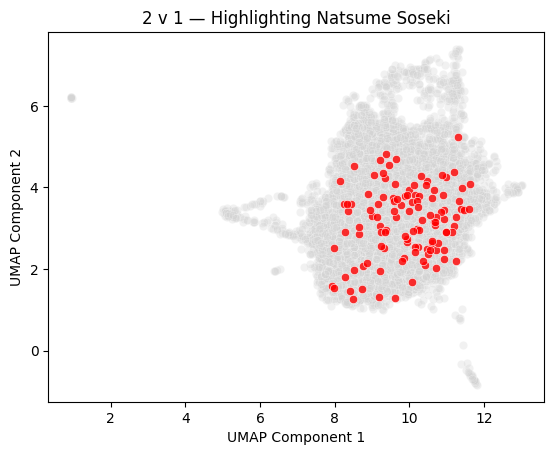

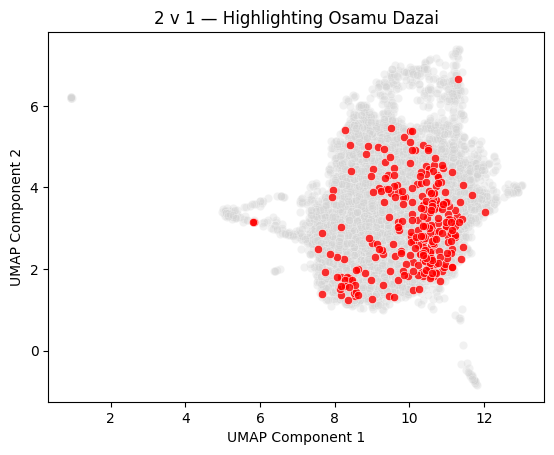

In [105]:
plot_all_authors()

In [ ]:
umap = UMAP(n_neighbors=10, n_components=5, min_dist=0.5, metric='', random_state=98)

u = umap.fit_transform(all_embeddings)

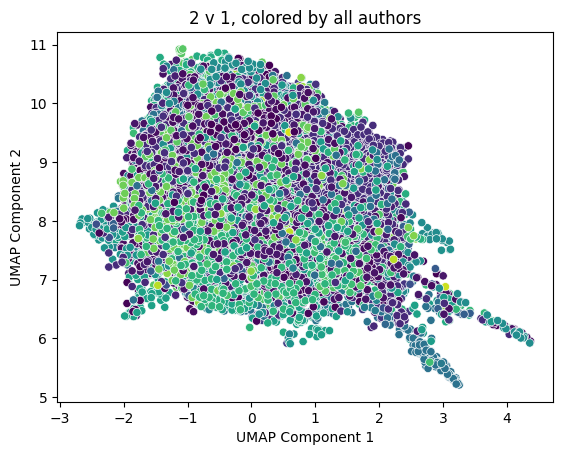

In [110]:
ax = sns.scatterplot(x=u[:, 0], y=u[:, 1], c=df['author_id'])
ax.set_ylabel('UMAP Component 2');
ax.set_xlabel('UMAP Component 1');
ax.set_title('2 v 1, colored by all authors');

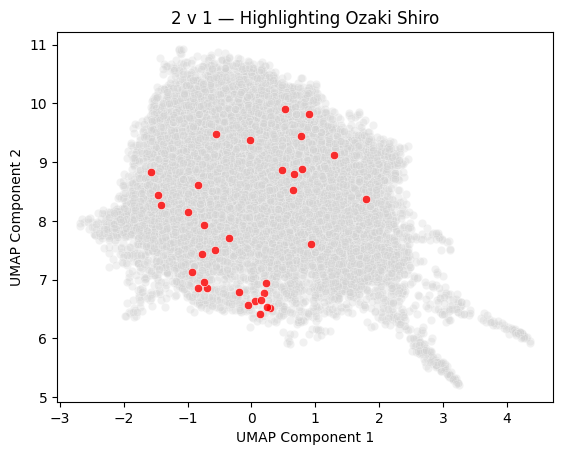

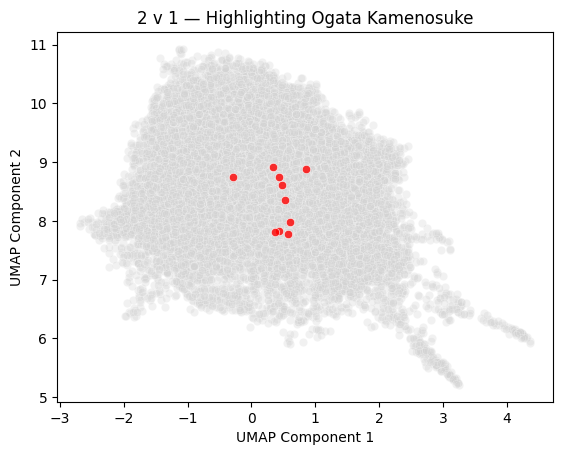

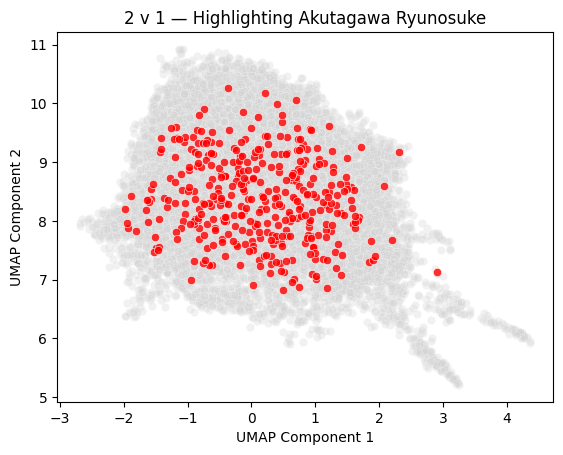

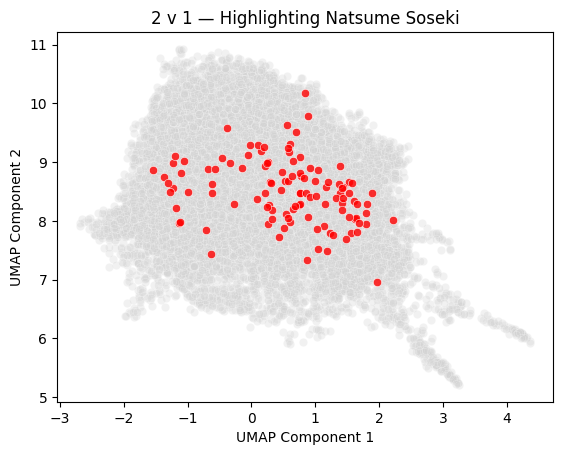

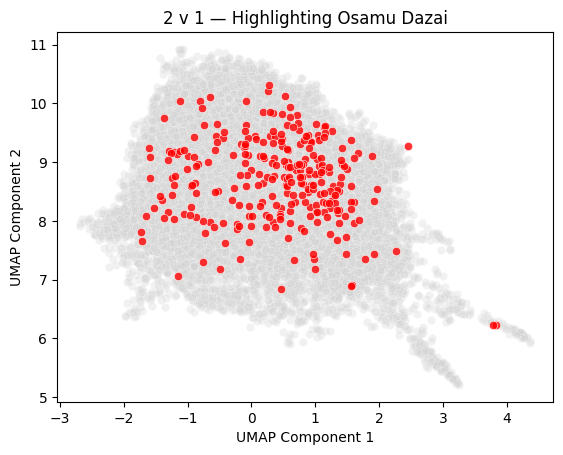

In [111]:
plot_all_authors()

In [112]:
umap = UMAP(random_state=98)

u = umap.fit_transform(all_embeddings)

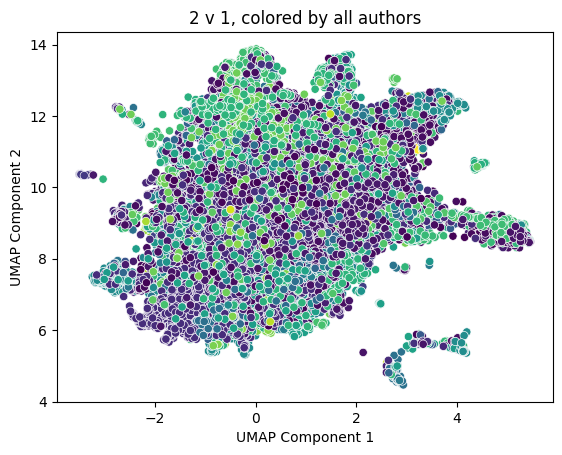

In [113]:
ax = sns.scatterplot(x=u[:, 0], y=u[:, 1], c=df['author_id'])
ax.set_ylabel('UMAP Component 2');
ax.set_xlabel('UMAP Component 1');
ax.set_title('2 v 1, colored by all authors');

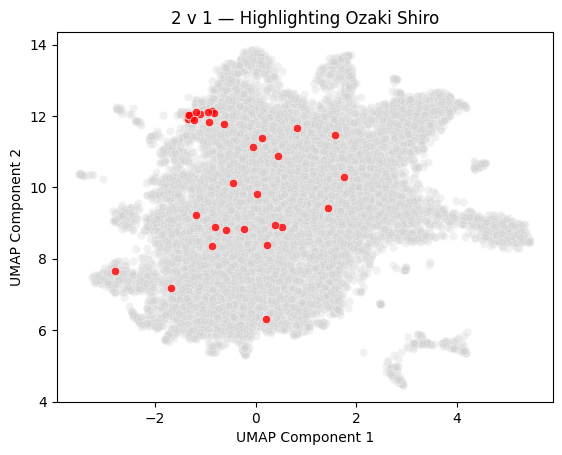

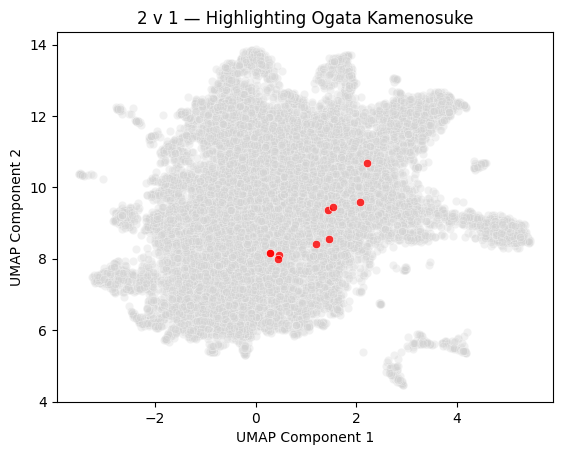

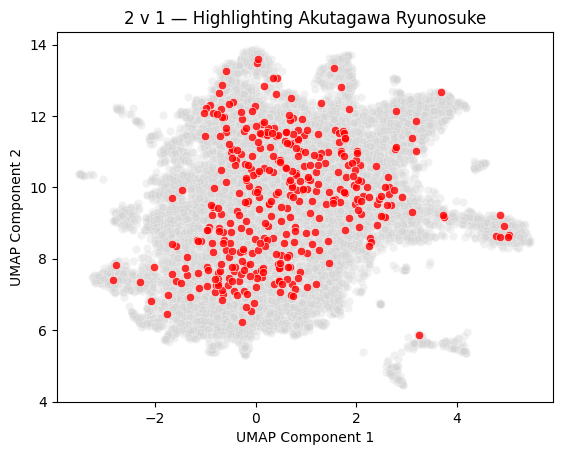

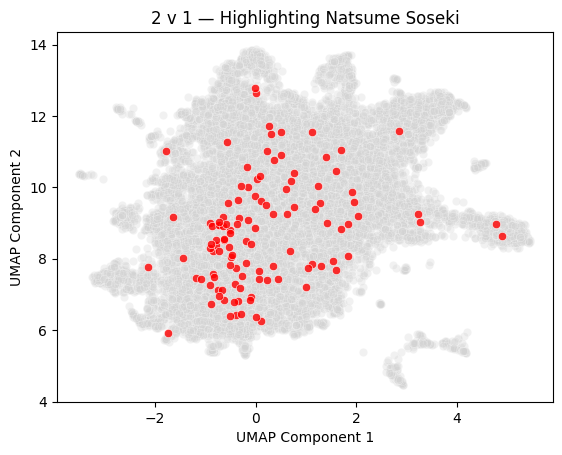

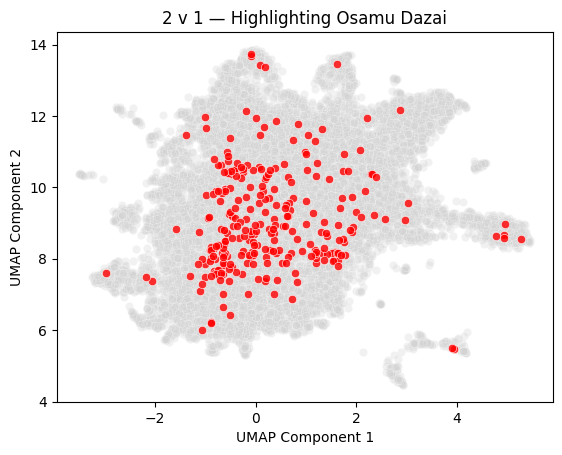

In [115]:
plot_all_authors()

In [116]:
umap = UMAP(n_neighbors=5, random_state=98)

u = umap.fit_transform(all_embeddings)

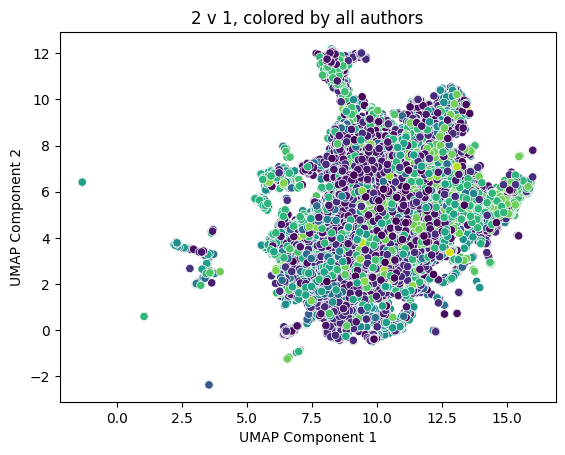

In [117]:
ax = sns.scatterplot(x=u[:, 0], y=u[:, 1], c=df['author_id'])
ax.set_ylabel('UMAP Component 2');
ax.set_xlabel('UMAP Component 1');
ax.set_title('2 v 1, colored by all authors');

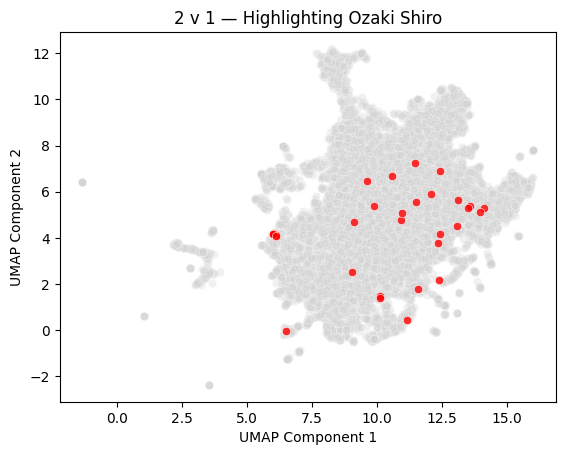

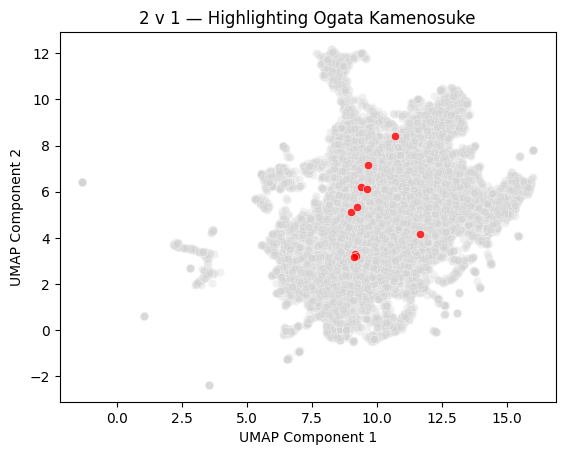

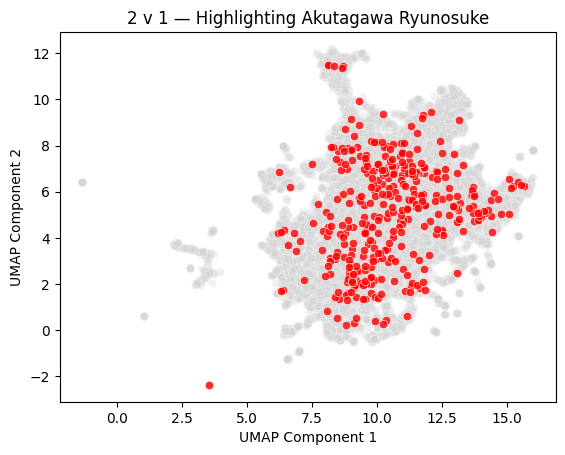

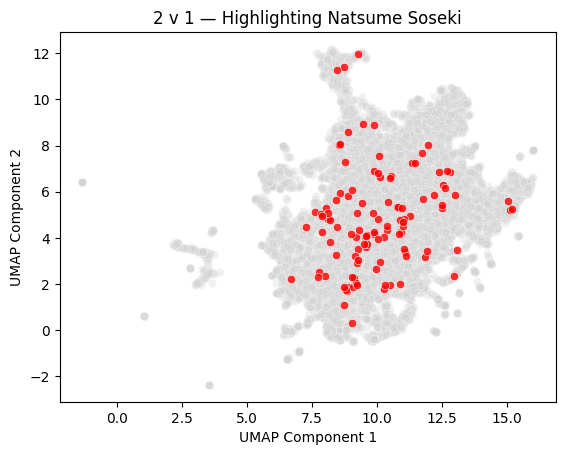

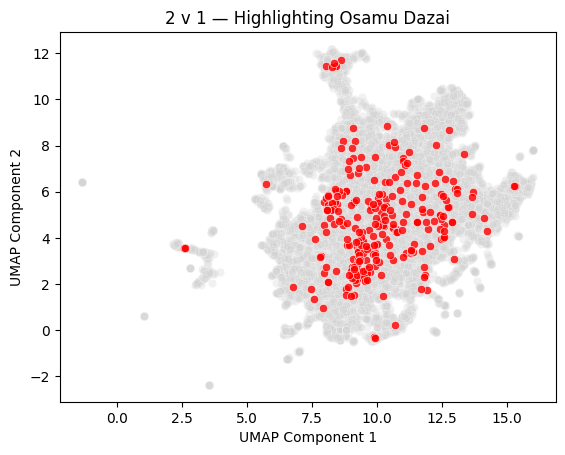

In [118]:
plot_all_authors()

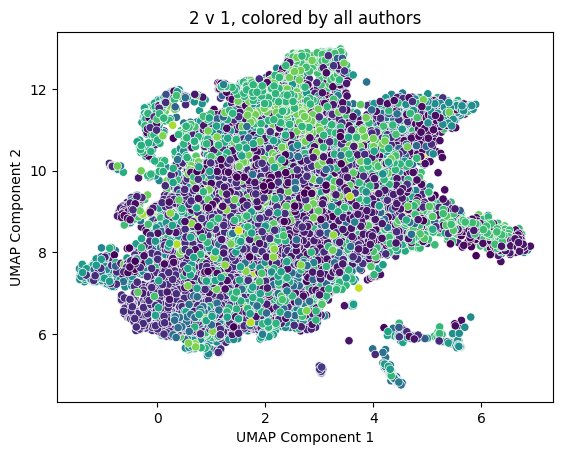

In [120]:
umap = UMAP(n_neighbors=30, random_state=98)

u = umap.fit_transform(all_embeddings)
ax = sns.scatterplot(x=u[:, 0], y=u[:, 1], c=df['author_id'])
ax.set_ylabel('UMAP Component 2');
ax.set_xlabel('UMAP Component 1');
ax.set_title('2 v 1, colored by all authors');

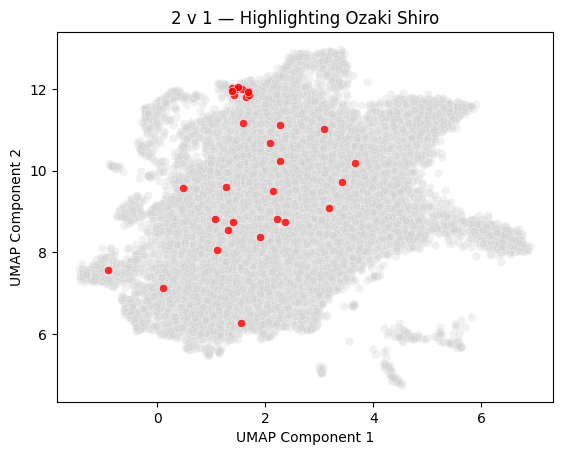

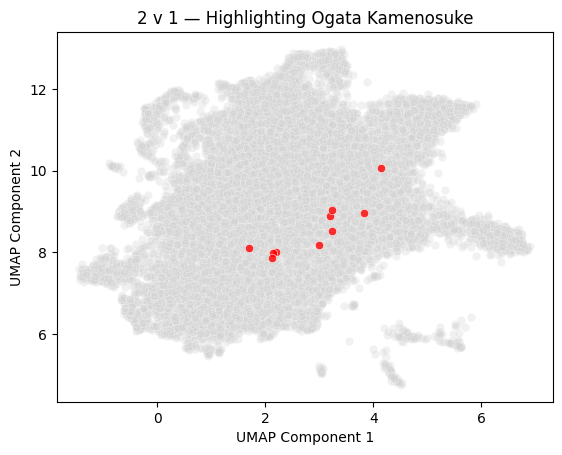

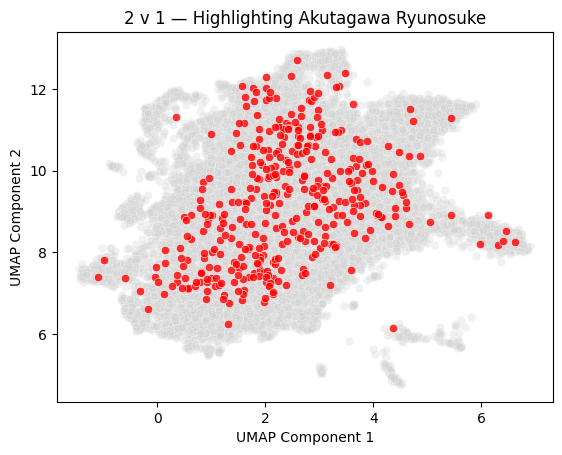

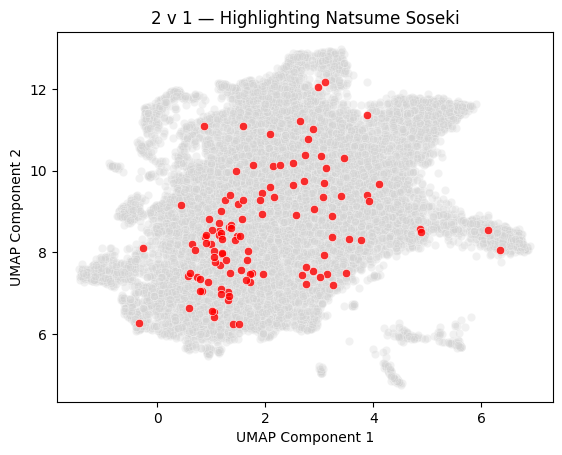

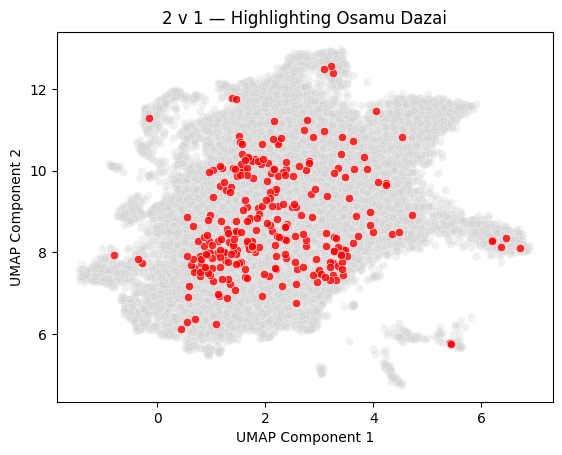

In [122]:
plot_all_authors()

In [123]:
umap = UMAP(n_neighbors=100, random_state=98)

u = umap.fit_transform(all_embeddings)

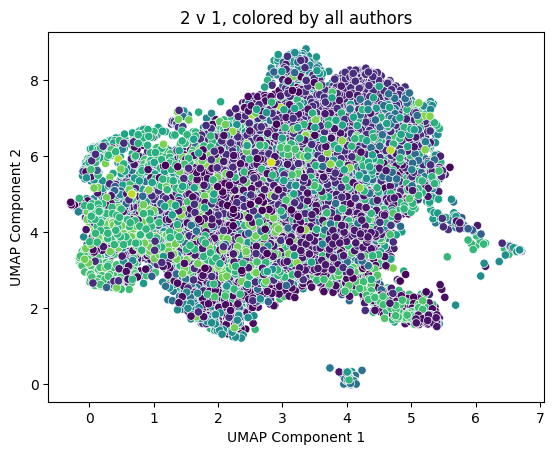

In [124]:
ax = sns.scatterplot(x=u[:, 0], y=u[:, 1], c=df['author_id'])
ax.set_ylabel('UMAP Component 2');
ax.set_xlabel('UMAP Component 1');
ax.set_title('2 v 1, colored by all authors');

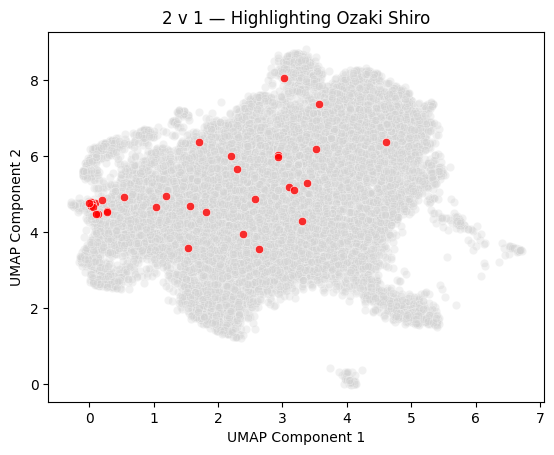

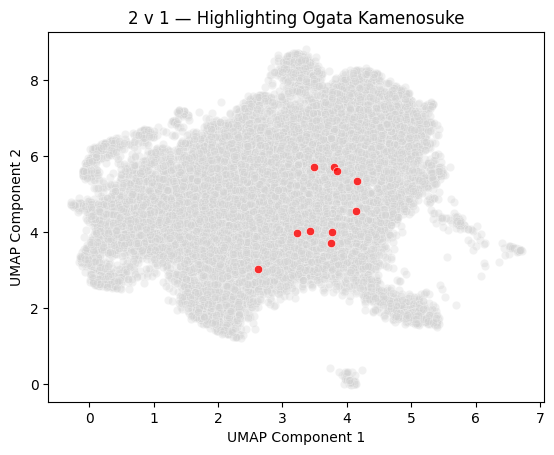

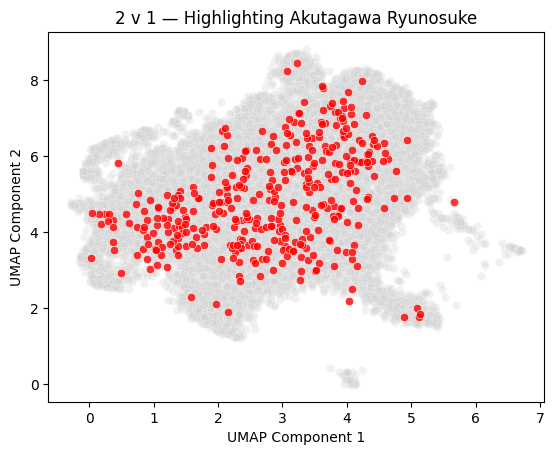

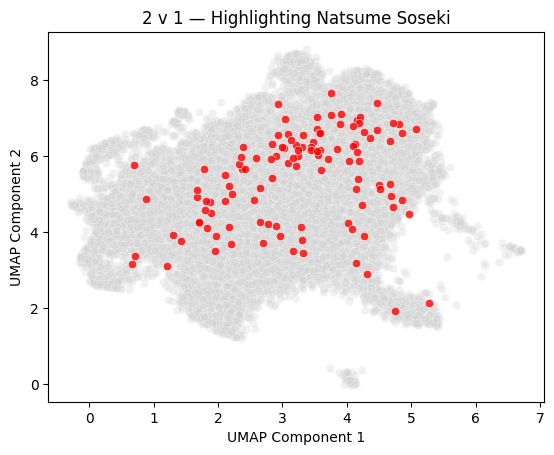

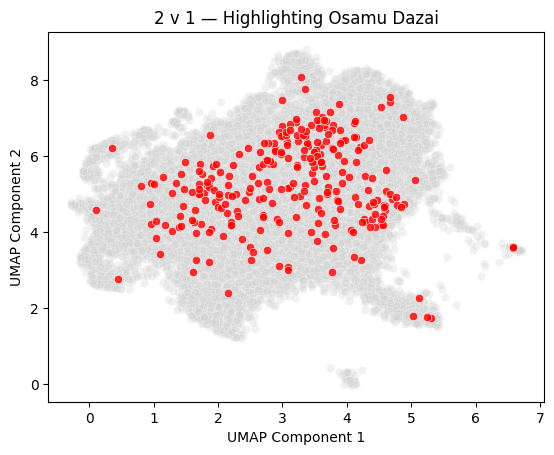

In [126]:
plot_all_authors()

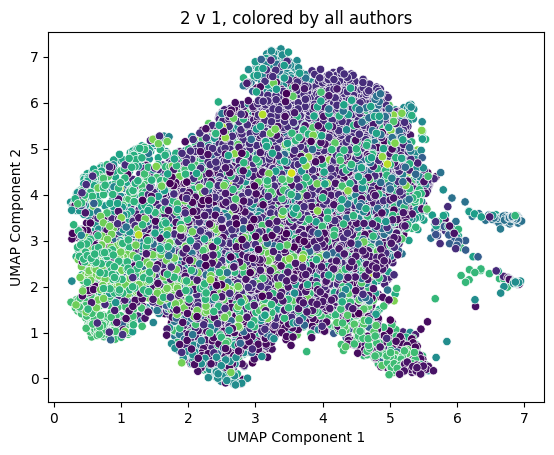

In [127]:
umap = UMAP(n_neighbors=200, random_state=98)

u = umap.fit_transform(all_embeddings)

ax = sns.scatterplot(x=u[:, 0], y=u[:, 1], c=df['author_id'])
ax.set_ylabel('UMAP Component 2');
ax.set_xlabel('UMAP Component 1');
ax.set_title('2 v 1, colored by all authors');

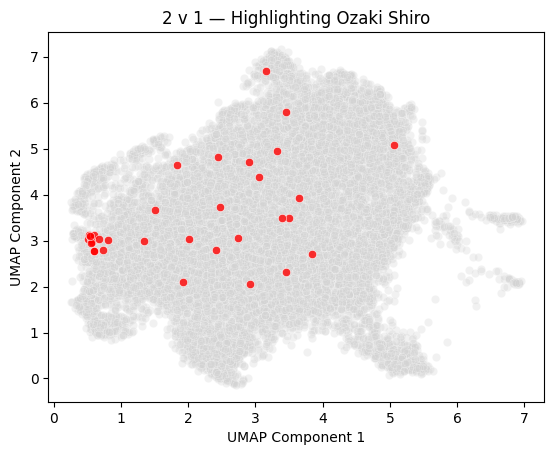

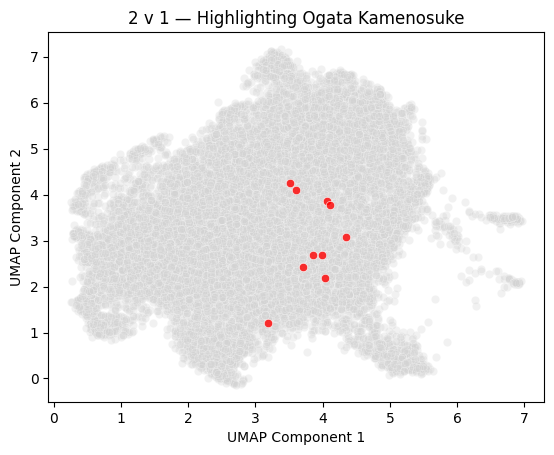

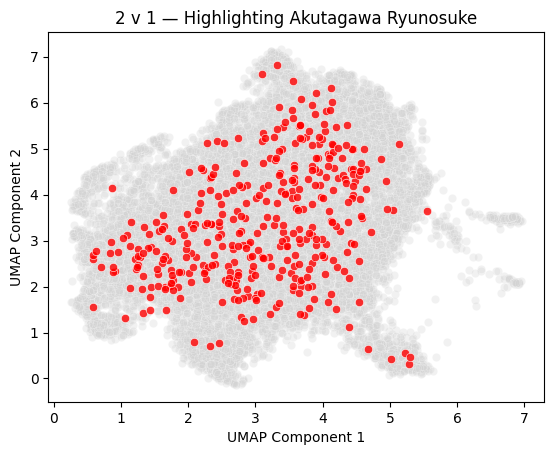

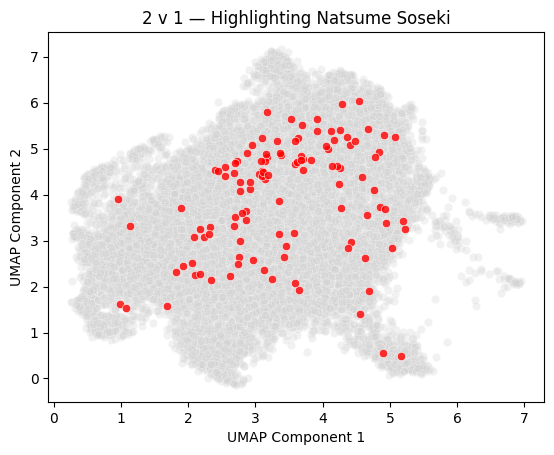

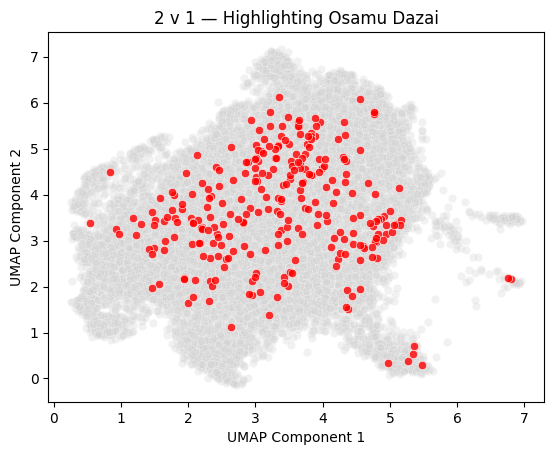

In [128]:
plot_all_authors()

In [31]:
umap = UMAP(n_neighbors=50,
            min_dist=0,
            random_state=98)


#### Clustering

In [11]:
hdbscan = HDBSCAN(min_samples=100, min_cluster_size=100, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

#### Tokenization

In [34]:
url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ja/master/stopwords-ja.json"
response = requests.get(url)
japanese_stop_words = response.json()
add_stop_words = [
    'ただ', 'なので','ござい',
    ]
japanese_stop_words = japanese_stop_words + add_stop_words


def tokenizer(text): # using fugashi
    tagger = Tagger()
    return [word.surface for word in tagger(text)]

vectorizer = CountVectorizer(tokenizer=tokenizer, stop_words=japanese_stop_words, ngram_range=(1,3))

#### c-TF-IDF / Representations

In [13]:
ctfidf = ClassTfidfTransformer()

keybert_model = KeyBERTInspired() 

nlp = spacy.load("ja_ginza")
pos_model = PartOfSpeech('ja_ginza')
mmr_model = MaximalMarginalRelevance(diversity='0.4')

representation = {
    'KeyBERT': keybert_model,
    'MMR': mmr_model,
    'POS': pos_model
}


#### Assembling

In [35]:
topic_model = BERTopic(
  language="japanese",

  embedding_model=None, # already have embeddings
  umap_model=umap,
  hdbscan_model=hdbscan,
  vectorizer_model=vectorizer,
  representation_model=representation,
  ctfidf_model=ctfidf,

  top_n_words=10,
  verbose=True
)

In [36]:
topics, probs = topic_model.fit_transform(df['text'].tolist(), embeddings=all_embeddings)

2025-08-11 17:06:22,441 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-11 17:06:49,331 - BERTopic - Dimensionality - Completed ✓
2025-08-11 17:06:49,332 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-11 17:06:50,049 - BERTopic - Cluster - Completed ✓
2025-08-11 17:06:50,054 - BERTopic - Representation - Fine-tuning topics using representation models.


RuntimeError: 
Failed initializing MeCab. Please see the README for possible solutions:

    https://github.com/polm/fugashi

If you are still having trouble, please file an issue here, and include the
ERROR DETAILS below:

    https://github.com/polm/fugashi/issues

issueを英語で書く必要はありません。

------------------- ERROR DETAILS ------------------------
arguments: [b'fugashi', b'-C']
param.cpp(69) [ifs] no such file or directory: c:\mecab\mecabrc
----------------------------------------------------------


In [30]:
df['text'].shape, all_embeddings.shape

((17366,), (17366, 384))

In [ ]:
umap.shape